In [8]:
import scipy as sp, numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import copy
from scipy.optimize import least_squares
from scipy.stats import zscore
import time
import pandas as pd
from scipy.stats import ttest_ind

# Get Data


X-Data

In [9]:
# Import Data
X0 = sp.io.loadmat('X48_0T.mat')['X_data_0T'] # load raw gene data with 0 for missing values

In [10]:
# Fill missing data with averages
def Average_Genes(X):
    # Return X with missing values averaged across columns
    X_avg = copy.deepcopy(X)
    num_col = len(X[0, :])
    num_row = len(X[:, 0])
    for col in range(num_col): # columns
        Num_NonZero = 0
        for row in range(num_row): # rows
            if X[row, col] == 0:
                Num_NonZero = Num_NonZero + 1
        if Num_NonZero != 25:
            Row_Avg = np.mean(X[:,col])*25/(25-Num_NonZero)

            for row in range(num_row): # rows
                if X[row, col] == 0:
                    X_avg[row, col] = Row_Avg;
    return X_avg

X_avg = Average_Genes(X0);

In [11]:
# Remove Non-Genes
X_avg = X_avg[:, 0:41000]
X0 = X0[:, 0:41000]

In [33]:
# Search for Nan in X_avg
def Find_nan(X):
    for col in range(len(X[0,:])):
        for row in range(len(X[:,0])):
            if np.isnan(X[row, col] is True):
                print(row, col)
Find_nan(X_avg)

Y-Data

In [12]:
# Load T data
Y = sp.io.loadmat('Y48_T.mat')['Y_data_T']

In [13]:
# Split Y Data
Time48 = Y[:, 0] # measurement time
Dose48 = Y[:,1] # radiation exposure in Gray
Patients48 = Y[:, 2]; # patient number

Reporter List

In [14]:
get_reporters = False
if get_reporters is True:
    t = time.time()

    Genes = pd.read_excel('BE188_Data.xlsx', sheet_name='Genes')
    Genes.values
    print(np.shape(Genes))
    Genes_T = np.transpose(Genes)

    elapsed = time.time() - t
    print('%f secomds elapsed' %elapsed)
else:
    pass

# Build Model with Entire Dataset

Percent Variance

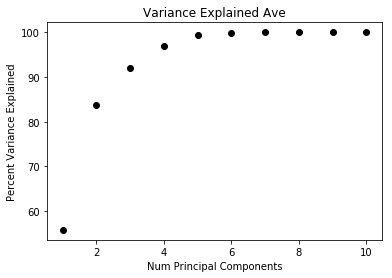

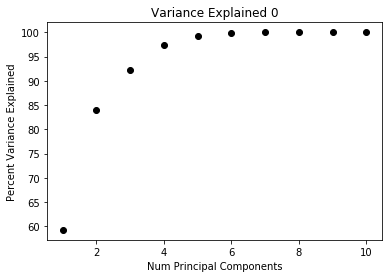

In [126]:
def Normalize(X, Y):
    zero_column = np.zeros(25)
    Xnorm = np.zeros((len(X[:,0]), len(X[0,:])))
    for col in range(len(X[0,:])):
        X_list = X[:,col].tolist() # so that we can use the count function
        if np.sum(X[:,col]) != 0 and len(X_list) != X_list.count(X_list[0]):
            Xnorm[:,col] = zscore(X[:,col])  # normalize the X data . This zscores the genes
    Ynorm = zscore(Y)  # normalize the Y data
    return Xnorm, Ynorm

def Plt_Variance(X, Y, num_components, title = 'Variance Explained', returnVariance = False):
    Xnorm, Ynorm = Normalize(X, Y)
    variance_array = np.zeros(num_components) # calculate variance with different numbers of PLSR
    for i in range(1,num_components+1):
        plsr = PLSRegression(n_components = i) # go for 10
        plsr.fit(Xnorm, Ynorm)
        variance_array[i-1] = 100*plsr.score(Xnorm,Ynorm)
    plt.scatter(range(1,num_components+1),variance_array, color = 'k')
    plt.title(title)
    plt.xlabel("Num Principal Components")
    plt.ylabel("Percent Variance Explained")
    plt.show()
    if returnVariance is True:
        return variance_array
    
Plt_Variance(X_avg, Dose48, 10, returnVariance = False, title = 'Variance Explained Ave');
Plt_Variance(X0, Dose48, 10, returnVariance = False, title = 'Variance Explained 0');

Print Scores

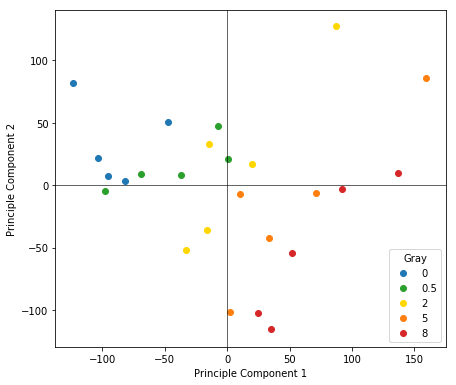

In [121]:
# Setup PLSR for scores
def Plt_Scores(X, Y, xbound = None, ybound = None, save = False):
    # input unnormalized data
    
    Xnorm, Ynorm = Normalize(X, Y)
    plsrScore = PLSRegression(n_components = 2)
    plsrScore.fit(Xnorm,Ynorm)
    scores = plsrScore.x_scores_ 

    # Plot scores
    Doses = [0, 0.5, 2, 5, 8]
    iDoses = ['i0','i0_5', 'i2', 'i5', 'i8']
    colors = ['tab:blue', 'tab:green', 'gold', 'tab:orange', 'tab:red']
    
    fig, axs = plt.subplots(figsize = (7,7))
    for i, dose in enumerate(Doses):
        iDoses[i] = np.where(Dose48 == Doses[i])[0] # Get indices of each dosage
        plt.scatter(scores[iDoses[i],0],scores[iDoses[i],1], c = colors[i], label = Doses[i]) # plot scores by radiation level

    # Format plot
    plt.legend(title = 'Gray', loc = 'lower right')
    plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    plt.xlim(xbound)
    plt.ylim(ybound)
    axs.set_aspect('equal')
    if save is True:
        plt.savefig('Scores.png', bbox_inches = 'tight')
        
Plt_Scores(X_avg, Dose48)

Plot Loadings

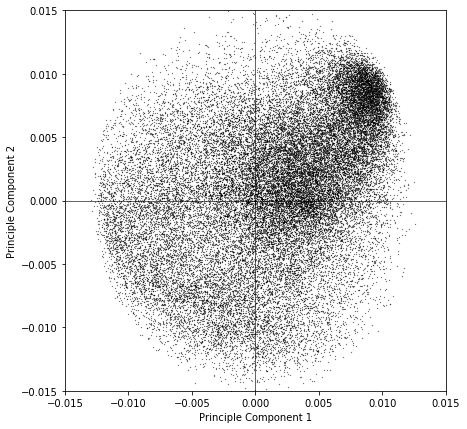

In [122]:
def Plt_Loadings(X, Y, xbound = None, ybound = None, save = False, size = 0.05):
    # input unnormalized data
    
    Xnorm, Ynorm = Normalize(X, Y)
    plsrScore = PLSRegression(n_components = 2)
    plsrScore.fit(Xnorm,Ynorm)
    loadings = plsrScore.x_loadings_ 

    # Identify high and low values (can be cut from code)
    count1 = 0
    count2 = 0
    To = 0.003
    i_high_rad = np.zeros(20000)
    i_low_rad = np.zeros(20000)
    for k in range(len(loadings[:,0])):
        if (loadings[k,0] > To) and (loadings[k,1] < -To):
            i_high_rad[count1] = k
            count1 += 1
        elif (loadings[k,0] < -To) and (loadings[k,1] > To):
            i_low_rad[count2] = k
            count2 += 1
        else:
            pass
    i_high_rad = np.trim_zeros(i_high_rad, trim = 'b').astype(int)
    i_low_rad = np.trim_zeros(i_low_rad, trim = 'b').astype(int)
    
    # Plot loadings
    marksize = size
    fig, axs = plt.subplots(figsize = (7,7))
    #plt.scatter(loadings[i_high_rad, 0], loadings[i_high_rad, 1], s = marksize*1.5, color = 'red')
    #plt.scatter(loadings[i_low_rad, 0], loadings[i_low_rad, 1], s = marksize*1.5, color = 'blue')
    plt.scatter(loadings[:,0],loadings[:,1], s = marksize, color = 'k')    
    
    # Format plot
    plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    plt.xlim(xbound)
    plt.ylim(ybound)
    axs.set_aspect('equal')
    if save is True:
        plt.savefig('Loadings.png', bbox_inches = 'tight')
        
Plt_Loadings(X_avg, Dose48, xbound = (-0.015, 0.015), ybound = (-0.015, 0.015), save = True)

Cross Validation

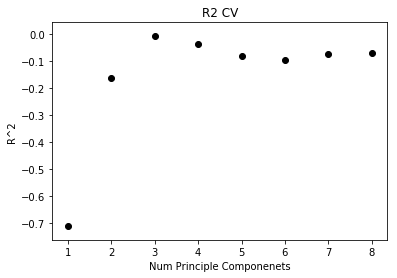

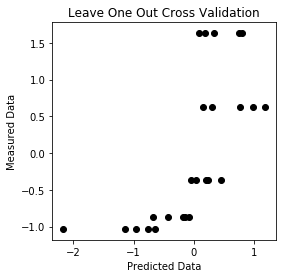

In [123]:
def R_squared(Ymod, Yobs):
    # Calculate R^2 based on difference between predicted and observed Y values
    R_2 = 1 - np.sum((Ymod-Yobs)**2)/np.sum(Yobs**2)
    #print('R squared = %.7f' % R_2) 
    
def CV(Y, Average = True, X = X0, num_components = 8):
    loo = LeaveOneOut()
    StanScale = StandardScaler()
    
    # Get Y predicted for variable number of components
    Ypredicted = np.zeros((len(X[:,0]),num_components))
    R2_array = np.zeros(num_components)
    n = 0
    for c in range(1,num_components+1):
        plsr = PLSRegression(n_components=c)
        for train_index, test_index in loo.split(X):
            Xtrain = X[train_index]
            if Average is True: # average X
                Xtrain = Average_Genes(Xtrain)
            Ytrain = Y[train_index]
            Xtrain_norm = StanScale.fit_transform(Xtrain)
            Ytrain_norm = zscore(Ytrain)
            plsr.fit(Xtrain_norm,Ytrain_norm)
            Ypredicted[n,c-1] = plsr.predict(StanScale.transform(X[test_index]))
            n += 1
        R2_array[c-1] = r2_score(Ypredicted[:, c-1], zscore(Y))
        n = 0
    return Ypredicted, R2_array
    
def Plot_Msmnt_vs_Prdct(YpredictLOO, Y):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(YpredictLOO, Y, color = 'k')
    plt.xlabel('Predicted Data')
    plt.ylabel('Measured Data');

Ypredicted, R2_array = CV(Dose48, Average = False, num_components = 8)
plt.scatter(range(1,9), R2_array, color = 'k')
plt.title('R2 CV')
plt.xlabel('Num Principle Componenets')
plt.ylabel('R^2')

Plot_Msmnt_vs_Prdct(Ypredicted[:, 2], zscore(Dose48))
plt.title('Leave One Out Cross Validation');

#rfecv should be able to use to find important features

# Reduce Data

T-Test Data

In [ ]:
# Get indices of each dose
Doses = [0, 0.5, 2, 5, 8]
iDoses = ['i0','i0_5', 'i2', 'i5', 'i8']
for i, dose in enumerate(Doses):
    iDoses[i] = np.where(Dose48 == Doses[i])[0] # Get indices of each dosage

# Compare expression of each gene across doses
sig_cols = np.zeros(len(X_avg[0,:]))
p_thresh = 0.05
count_sig_cols = 0

loo = LeaveOneOut()
for col in range(len(X_avg[0,:])): # go through 30 columns

    # get ttest values for each 
    count_sig_p = 0

    for train, test in loo.split(iDoses): # use LOO splitter to skip self-comparisons
        test1 = np.asscalar(test)
        dist1 = X_avg[iDoses[test1], col]
        for k in train:
            k1 = np.asscalar(k)
            dist2 = X_avg[iDoses[k1], col]
            p_value = ttest_ind(dist1, dist2)[1]
            
            if p_value < p_thresh:
                count_sig_p += 1

            
    if count_sig_p >= 16: # if gene is differentially expressed across all but 1 radiation levels
        sig_cols[count_sig_cols] = col
        count_sig_cols += 1

sig_cols = np.trim_zeros(sig_cols, trim = 'b').astype(int) # remove trailing zeros
#np.save('Ttest_4Sig.npy', sig_cols)

Rerun with reduced data

In [124]:
# Load reduced data
Sig4 = np.load('Ttest_4Sig.npy')
X4sig = X_avg[:, Sig4]
X4sig0 = X0[:, Sig4]

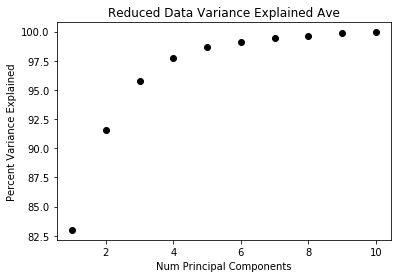

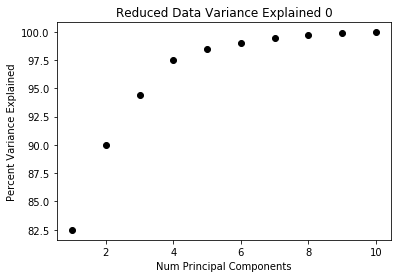

In [127]:
# Plot percent variance explained
Plt_Variance(X4sig, Dose48, 10, returnVariance = False, title = 'Reduced Data Variance Explained Ave')
Plt_Variance(X4sig0, Dose48, 10, returnVariance = False, title = 'Reduced Data Variance Explained 0')

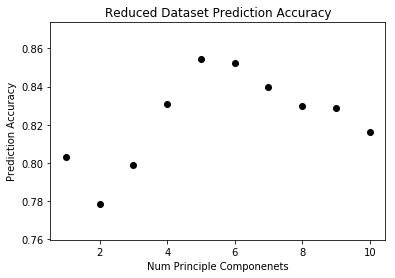

In [129]:
# Plot cross validation R^2
Ypredicted, R2_array = CV(Dose48, Average = False, X = X4sig, num_components = 10)
plt.scatter(range(1,11), R2_array, color = 'k')
plt.title('Reduced Dataset Prediction Accuracy')
plt.xlabel('Num Principle Componenets')
plt.ylabel('Prediction Accuracy');
plt.savefig('Reduced_Dataset_Prediciton_Accuracy')

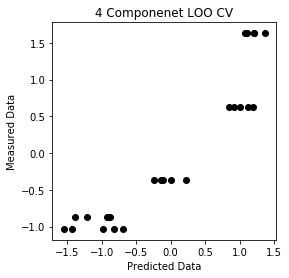

In [114]:
# Plot observation vs prediction
Plot_Msmnt_vs_Prdct(zscore(Ypredicted[:, 4]), zscore(Dose48))
plt.title('4 Componenet LOO CV');

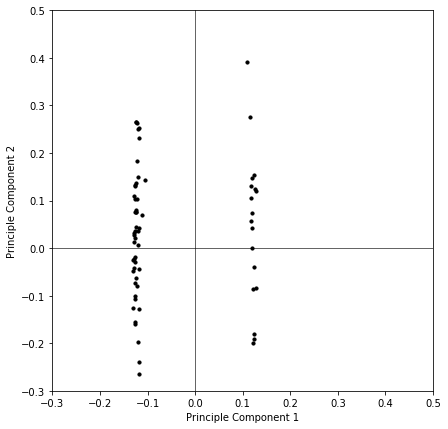

In [130]:
# Plot Loadings
Plt_Loadings(X4sig, Dose48, size = 10, xbound = (-0.3, 0.5), ybound= (-0.3, 0.5))